# Myers Briggs Type Indicator (MBTI) Project
## By The Introverts 
1. Nan Lin
2. Zack Pan
3. Ben Khuong
4. Tomohiko Ishihara
5. Donya Fozoonmayeh

<img src="Pictures/MBTIgrid.jpg" alt="Drawing" style="width: 500px;"/>

# Background

Myers Briggs Type Indicator (MBTI) is a personality questionnaire based on Carl Jung's theory of psychological types. The purpose of the test is to indicate people's various psychological preferences in their perception of the world and decision making. MBTI breaks down these preferences into four dichotomies or opposite pairs, which results in 16 different psychological types: 


1. Introversion vs Extroversion: "Where do you prefer to focus your attention and get your energy from?"
2. Sensing vs Intuition: "How do you prefer to take in information?"
3. Thinking vs Feeling: "How do you make decisions?"
4. Judging vs Perceiving: "How do you deal with the outer world?"

<img src="Pictures/personality_key.png" alt="Drawing" style="width: 500px;"/>

Although MBTI is not as popular as before, due to its poor validity and reliability, it is still widely used in the business sector. Therefore, we thought it would be interesting to look at a dataset we found on Kaggle. The dataset contains about 50 posts from 8600 individuals on a <a href="https://www.personalitycafe.com/myers-briggs-forum/">Personality Cafe forum</a>, along with their personality type. We thought it would be interesting to see if we could use machine learning to predict personality types, using posts. 

# Loading Data & Packages

Here we load the raw dataset, along with all the packages we used in our project:

In [1]:
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import string 
import re
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from helperfunctions.PrettyConfusionMatrix import print_cm
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
import time
import warnings
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings('ignore')
from random import choice
import lightgbm as lgb
import gc
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# Loading MBTI raw dataset
mbti = pd.read_csv('data/mbti_1.csv') 

# Data Preprocessing

Since the raw data was posts from a forum, we had to do a lot of preprocessing and feature engineering.

## Raw data 
First, lets take a look at the distribution of the MBTI personality types.

<BarContainer object of 16 artists>

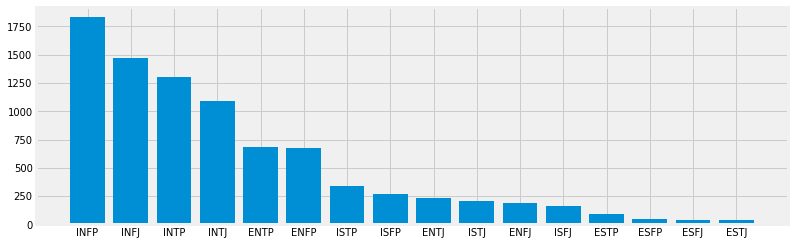

In [4]:
# Counting the numbers of users per personality type
stat = mbti['type'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(stat.index,stat.values)

As it can be clearly observed in the above plot, there is a huge imbalance between the personality types. Therefore,  instead of just looking at the personality type, we decided to look at each aspect of personality. 

In [5]:
# Personality type for each aspect 

# Extroversion vs. Introversion
mbti['EorI']= mbti['type'].apply(lambda x:x[0])

# Intuition vs. Sensing
mbti['NorS']= mbti['type'].apply(lambda x:x[1])

# Thinking vs. Feeling
mbti['TorF']= mbti['type'].apply(lambda x:x[2])

# Judging vs. Perceiving
mbti['JorP']= mbti['type'].apply(lambda x:x[3])

Here, we look at the number of users for each personality aspect. Again, there is an imbalance between the types for some of the groups. 

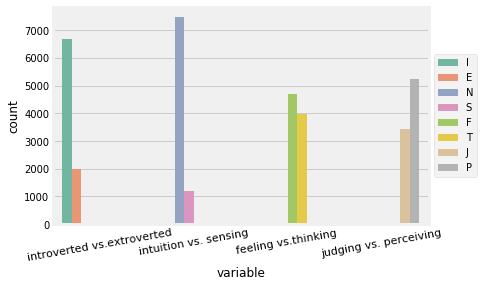

In [6]:
ax = sns.countplot(x='variable',hue='value',data=pd.melt(mbti.iloc[:,2:]),palette="Set2")
ax.set_xticklabels(["introverted vs.extroverted", "intuition vs. sensing", 
                    "feeling vs.thinking ", "judging vs. perceiving", 
                    ], rotation=10, fontsize=11)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Before cleaning up the posts, we thought it would interesting to look at the average comment length and the its variation between uses. 

In [7]:
mbti['avg_comment_length'] = mbti['posts'].apply(lambda x: len(x.split())/50)
mbti['comment_length_var'] = mbti['posts'].apply(lambda x: np.var([len(sentence.split()) for sentence in x.split('|||')]))

In [12]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,19.34,196.4576


### Cleaning the posts
In this section, we clean the text and standardize it:
1. The posts for each user are separatered by "|||", therefore, we removed them
2. Removed links, punctuation, MBTI-types words(a lot of users refer to their own personality types in their posts)
3. Lowercase
4. Lemmatized words
5. Removed stop words and words less than 3 characters 

In [8]:
# finding personality types list 
types = list(mbti.iloc[:,0].unique())
types = [t.lower() for t in types]
types

['infj',
 'entp',
 'intp',
 'intj',
 'entj',
 'enfj',
 'infp',
 'enfp',
 'isfp',
 'istp',
 'isfj',
 'istj',
 'estp',
 'esfp',
 'estj',
 'esfj']

In [9]:
def post_preprocess(df):
    i = 0
    post_list = []
    length = len(df)
    lemmatiser = WordNetLemmatizer() # Lemmatizing the words 
    print('Processing... Be patient')
    
    for row in df.iterrows():
        # Progress bar
        i+=1
        if (i % 500 == 0 or i == length):
            print(f"Progress bar：{round(i/length*100)}%")
        
        # Cleaning the posts 
        posts = row[1].posts
        posts = re.sub(r'\|\|\|',' ',posts)
        posts = re.sub(r'http[\S]*', '', posts).lower()
        posts = re.sub("[^a-z\s]", ' ', posts)
        posts = ' '.join([lemmatiser.lemmatize(w) for w in posts.split(' ') if w not in stopwords.words('english')])
        
        # Removing personality types
        for t in types:
            posts = posts.replace(t,'')
        post_list.append(posts)
        
    return np.array(post_list)      

It takes about **15 minutes** to run the above function for cleaning the posts. Please uncomment the line below to run the above function. 

In [10]:
# Processed_post = post_preprocess(mbti)

In [11]:
# To save time, we load the preprocessed posts
processed_post = pd.read_csv('data/mbti_preprocessed_1.csv')
processed_post.drop('Unnamed: 0',axis=1,inplace=True)
processed_post.head()

,type,posts,processed_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,moment sportscenter top ten play pr...
1,ENTP,'I'm finding the lack of me in these posts ver...,finding lack post alarming sex boring positi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know blessing...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear enjoyed conversation day esoteric ...
4,ENTJ,'You're fired.|||That's another silly misconce...,fired another silly misconception approachi...


### Vectorizing Personality Types
Here we convert each personality aspect into a binary code. For example, an introverted person would be 0 and an extroverted person would be 1. 

In [14]:
# Converting each personality aspect into binary code
type_map = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
types = {'EorI':'Extroversion vs. Introversion', 'NorS': 'Intuition vs. Sensing',
                 'TorF': 'Thinking vs. Feeling','JorP': 'Judging vs. Perceiving'}

def type_preprocess(df):
    for i in range(2,6):
        df.iloc[:,i] = df.iloc[:,i].map(type_map)
    return df

In [15]:
mbti = type_preprocess(mbti)
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0,21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0,19.34,196.4576


## Feature Engineering

### Vectorizing Posts
Using TFIDF, we created a bag of words representation of each user's posts.

In [16]:
# TfidfVectorizer
# Parameters used here are the  best for model performance
vectorizer_tfidf = TfidfVectorizer(min_df=0.05, max_df=0.85, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf.fit(processed_post['processed_posts'])
word_tfidf = vectorizer_tfidf.transform(processed_post['processed_posts'])
word_tfidf_df = pd.DataFrame(data = word_tfidf.toarray(), columns = vectorizer_tfidf.get_feature_names())

In [20]:
word_tfidf_df.head()

,ability,able,absolute,absolutely,abstract,accept,according,account,accurate,across,...,year ago,year old,yep,yes,yesterday,yet,young,younger,youtube,yup
0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.067997,0.000000,0.083075,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.00000,0.038307,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.12246,0.044400,0.000000,0.106856,0.0,0.0,0.0,0.0,0.064077,0.0,...,0.000000,0.063801,0.000000,0.060355,0.0,0.0,0.0,0.0,0.0,0.081823
3,0.00000,0.071834,0.066683,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.059121,0.000000,0.055929,0.0,0.0,0.0,0.0,0.0,0.000000


We also use the `CountVectorizer` object to look at the frequency of each word for each user.

In [17]:
# CountVectorizer
vectorizer_ct = CountVectorizer(stop_words='english',analyzer='word',input='content', 
                                 decode_error='ignore', max_df=0.48,min_df=5,
                                 token_pattern=r'\w{1,}', max_features=1625, ngram_range=(1,2)) # to compare two methods, I limit max_features=1625
vectorizer_ct.fit(processed_post['processed_posts'])
word_ct = vectorizer_ct.transform(processed_post['processed_posts'])
word_ct_df = pd.DataFrame(data = word_ct.toarray(), columns = vectorizer_ct.get_feature_names())

In [19]:
word_ct_df.head()

,ability,able,absolute,absolutely,abstract,accept,according,account,accurate,act,...,year ago,year old,yep,yes yes,yesterday,young,younger,youtube,yup,zone
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,2,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Manual Features

#### Sentiment Score
*Caution: Takes a few minutes to run.*

In [23]:
# Sentiment Score of clean posts
analyzer = SentimentIntensityAnalyzer()
scores = []
length_p = len(processed_post)
for i in range(length_p):
    score = analyzer.polarity_scores(processed_post['processed_posts'][i])['compound']
    scores.append(score)
    # Print Progress 
    if (i % 500 == 0 or i == length_p-1):
            print(f"Progress bar：{round(i/length_p*100)}%")

Progress bar：0%
Progress bar：6%
Progress bar：12%
Progress bar：17%
Progress bar：23%
Progress bar：29%
Progress bar：35%
Progress bar：40%
Progress bar：46%
Progress bar：52%
Progress bar：58%
Progress bar：63%
Progress bar：69%
Progress bar：75%
Progress bar：81%
Progress bar：86%
Progress bar：92%
Progress bar：98%
Progress bar：100%


In [24]:
mbti['Sentiment'] = scores

#### Ellipses count
Counting the number of ellipsies used per user, which is an indicator of long posts.

In [25]:
ellipses_count = [len(re.findall(r'\.\.\.\|\|\|',posts)) for posts in mbti['posts']]
mbti['Ellipses'] = ellipses_count

####   Exclamation count
Counting the number of exclamation marks used per user. 

In [26]:
exclamation_count = [len(re.findall(r'!',posts)) for posts in mbti['posts']]
mbti['Exclamation'] = exclamation_count

#### Question count
Counting the number of question marks used per user. 

In [27]:
question_count = [len(re.findall(r'\?',posts)) for posts in mbti['posts']]
mbti['Question'] = question_count

#### Link count
Counting the number of links used per user. 

In [28]:
# For each user, remove ||| to make it easier to find links. 
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in mbti['posts']]
link_count = [len(re.findall(r'http[\S]* ', posts)) for posts in user_posts]
mbti['Links'] = link_count

#### Picture count
Counting the number of pictures used per user. 

In [29]:
question_count = [len(re.findall(r'(\.png)|(\.jpg)',posts)) for posts in mbti['posts']]
mbti['Picture'] = question_count

#### Emojies count
Counting the number of Slack-style(e.g. `:smile:`) and most common text-style(e.g. `:)`) emojies per user.

In [32]:
def find_emoji(text):
    text = text.lower()
    text = re.sub(r'\|\|\|', ' ', text)
    
    slack_style_emojies = re.findall(r':[\w\d]+(\-[\w\d]+)?:', text)
    text_style_emojies = re.findall(r':[\-|\s]?[d|\)|\(|p]', text)
    
    return slack_style_emojies + text_style_emojies

In [33]:
mbti['Emojies'] = mbti['posts'].map(lambda x: len(find_emoji(x)))

#### Upper case count
Counting the number of uppercase words per user.

In [34]:
def del_punct(text):
    regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
    return regex.sub("", text)

In [ ]:
temp = mbti['posts'].apply(lambda x: del_punct(x))
mbti['Upper'] = temp.apply(lambda x: len([x for x in x.split() if x.isupper()]))

#### Additional Cleaning
Here we get rid of `NaN` sentiment scores. We also scale negative numbers with `MinMaxScalar`, since it can't be handled by Naive Bayes.

In [36]:
# Getting rid of NaNs
mbti.fillna(value=0, inplace=True)

# Scaling sentiment score with MinMax 
min_max_scaler = MinMaxScaler()
sentiment_scaled = min_max_scaler.fit_transform(np.array(mbti['Sentiment']).reshape(-1, 1))
mbti['Sentiment'] = sentiment_scaled

# References
1. https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/preferences.html
2. https://www.npr.org/2018/09/22/650019038/how-the-myers-briggs-personality-test-began-in-a-mothers-living-room-lab